In [2]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt

# **Creation des fichiers de restarts**

In [108]:
#Mask for each grid
MASKdataset    = xr.open_dataset('/thredds/idris/work/ues27zx/eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False) 

restarts_file = "/thredds/idris/work/ues27zx/Restarts/"

In [67]:
zos    = np.load("/data/mtissot/simus_predicted/zos.npy")       #sea surface height  = ssh  t*y*x
so     = np.load("/data/mtissot/simus_predicted/so.npy")        #salinity t*z*y*x
thetao = np.load("/data/mtissot/simus_predicted/thetao.npy")    #temperature t*z*y*x

In [68]:
print(np.shape(zos))
print(np.shape(so))

(2, 331, 360)
(2, 75, 331, 360)


In [98]:
xarray_zos    = xr.DataArray(zos, dims=("time_counter", "y", "x"), name="zos")
xarray_so     = xr.DataArray(so, dims=("time_counter", "deptht", "y", "x"), name="so")
xarray_thetao = xr.DataArray(thetao, dims=("time_counter", "deptht", "y", "x"), name="thetao")

### **Densité et niveaux de profondeurs**

### Densité

- Recuperer S,T et depth
- Lancer la fonction insitu

In [94]:
f = "/scratchu/mtissot/SIMUp6Y/CM65v420-LR-CdL-pi-01_18500101_19491231_1M_so.nc.YAVG.nc" 
array = xr.open_dataset(f, decode_times=False)
depth = np.tile(array.deptht.values, (1,360,331,1)).transpose(0,3,2,1)  #thickness of all 75 levels
np.shape(depth)

(1, 75, 331, 360)

In [95]:
rau0 = 10e3
def insitu(theta0,S,Z):
    rho = rau0 * insitu_anom(theta0,S,Z) + rau0
    return rho

def insitu_anom(theta0,S,Z):    
    zsr=np.sqrt(np.abs(S))
    zt=theta0
    zs=S
    zh=Z
    # compute volumic mass pure water at atm pressure
    zr1 = ((((6.536332e-9*zt-1.120083e-6)*zt+1.001685e-4)*zt-9.095290e-3)*zt+6.793952e-2)*zt+999.842594
    # seawater volumic mass atm pressure
    zr2 = (((5.3875e-9*zt-8.2467e-7)*zt+7.6438e-5)*zt-4.0899e-3)*zt+0.824493
    zr3 = (-1.6546e-6*zt+1.0227e-4)*zt-5.72466e-3
    zr4 = 4.8314e-4

    # potential volumic mass (reference to the surface)
    zrhop = (zr4*zs+zr3*zsr+zr2)*zs+zr1

    # add the compression terms
    ze = (-3.508914e-8*zt-1.248266e-8)*zt-2.595994e-6
    zbw= (1.296821e-6*zt-5.782165e-9)*zt+1.045941e-4
    zb = zbw+ze*zs

    zd = -2.042967e-2
    zc = (-7.267926e-5*zt+2.598241e-3)*zt+0.1571896
    zaw= ((5.939910e-6*zt+2.512549e-3)*zt-0.1028859)*zt-4.721788
    za = (zd*zsr+zc)*zs+zaw

    zb1= (-0.1909078*zt+7.390729)*zt-55.87545
    za1= (( 2.326469e-3*zt+1.553190)*zt-65.00517 )*zt+1044.077
    zkw= (((-1.361629e-4*zt-1.852732e-2)*zt-30.41638 )*zt+2098.925)*zt+190925.6
    zk0= (zb1*zsr+za1 )*zs+zkw

    prd=( zrhop / (  1.0 - zh / ( zk0 - zh * ( za - zh * zb ) )  ) - rau0 ) / rau0

    return prd

In [96]:
def sigma_n(theta0,S,n):
    dpr4=4.8314e-4
    dpd=-2.042967e-2 
    dprau0 = 1000.
    pref = n * 1000.
    dlref = pref
    #sigmai = 0.*theta0
    dlrs = np.sqrt(np.abs(S))
    dlt = theta0
    dls = S
    # Compute the volumic mass of pure water at atmospheric pressure.
    dlr1=((((6.536332e-9*dlt-1.120083e-6)*dlt+1.001685e-4)*dlt-9.095290e-3)*dlt+6.793952e-2)*dlt+999.842594e0
    # Compute the seawater volumic mass at atmospheric pressure.
    dlr2=(((5.3875e-9*dlt-8.2467e-7)*dlt+7.6438e-5)*dlt-4.0899e-3)*dlt+0.824493e0
    dlr3=(-1.6546e-6*dlt+1.0227e-4)*dlt-5.72466e-3
    # Compute the potential volumic mass (referenced to the surface).
    dlrhop=(dpr4*dls+dlr3*dlrs+dlr2)*dls+dlr1
    # Compute the compression terms.
    dle=(-3.508914e-8*dlt-1.248266e-8)*dlt-2.595994e-6
    dlbw=(1.296821e-6*dlt-5.782165e-9)*dlt+1.045941e-4
    dlb=dlbw+dle*dls
    dlc=(-7.267926e-5*dlt+2.598241e-3)*dlt+0.1571896e0
    dlaw=((5.939910e-6*dlt+2.512549e-3)*dlt-0.1028859e0)*dlt-4.721788e0
    dla=(dpd*dlrs+dlc)*dls+dlaw
    dlb1=(-0.1909078e0*dlt+7.390729e0)*dlt-55.87545e0
    dla1=((2.326469e-3*dlt+1.553190e0)*dlt-65.00517e0)*dlt+1044.077e0
    dlkw=(((-1.361629e-4*dlt-1.852732e-2)*dlt-30.41638e0)*dlt+2098.925e0)*dlt+190925.6e0
    dlk0=(dlb1*dlrs+dla1)*dls+dlkw
    # Compute the potential density anomaly.
    sigmai=dlrhop/(1.0e0-dlref/(dlk0-dlref*(dla-dlref*dlb)))-dprau0
    return sigmai

(2, 75, 331, 360)
(2, 75, 331, 360)


/tmp/ipykernel_281849/3494818316.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar();


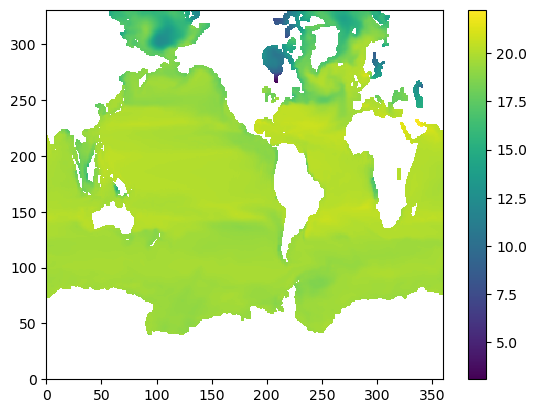

In [102]:
rho_insitu = insitu(thetao,so,depth)  #densité N 
rho0       = sigma_n(thetao,so,n=0)   #densité ? 

xarray_rho_insitu = xr.DataArray(thetao, dims=("time_counter", "deptht", "y", "x"), name="rho_insitu")
xarray_rho0       = xr.DataArray(thetao, dims=("time_counter", "deptht", "y", "x"), name="rho0")

print(np.shape(rho_insitu))
print(np.shape(rho0))

plt.pcolor(rho0[-1,0]);  #densité de surface
plt.colorbar();

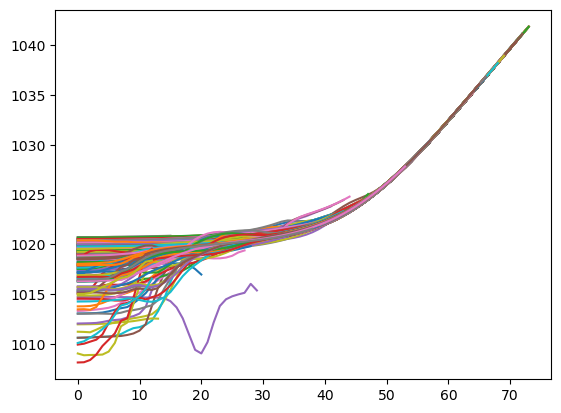

In [103]:
for i in range(0,331,10):
    for j in range(0,360,10):
        plt.plot(rho_insitu[-1,:,i,j])
# observation de l'evolution de la densité en profondeur

In [104]:
e3t = MASKdataset["e3t_0"].values[0]  #diff e3t /depth ?
diff_rho_insitu_z = np.diff(rho_insitu[-1], axis=0)/e3t[:-1] #differentiel de la densité

print(np.shape(rho_insitu[-1]))
print(np.shape(e3t[:-1]))
print(np.shape(diff_rho_insitu_z))

(75, 331, 360)
(74, 331, 360)
(74, 331, 360)


/tmp/ipykernel_281849/2404986750.py:5: RuntimeWarning: All-NaN slice encountered
  plt.pcolor(np.nanmin(diff_rho_insitu_z, axis=0) < 0, alpha=alpha_values)  # Plot with transparency


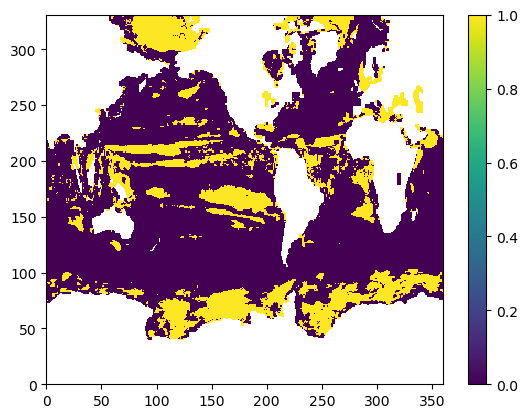

In [224]:
c = np.isnan(zos[-1])  # Boolean array indicating NaN values
alpha_values = np.where(c, 0, 1.0)  # Set transparency to 0.5 where NaN, otherwise 1.0

#Min de la diff selon la profondeur
plt.pcolor(np.nanmin(diff_rho_insitu_z, axis=0) < 0, alpha=alpha_values)  # Plot with transparency
plt.colorbar()
plt.show()

In [41]:
#np.save("/data/mtissot/simu_restart/rho_insitu.npy",pho)

In [ ]:
#pho = np.load("/data/mtissot/simu_restart/rho_insitu.npy")

### Epaisseur des niveaux de profondeurs

- Renommer les dimensions dans les fichiers de restart x -> xx, y->yy
- Recuperer le masque 
- Pour chaque fichier de restart (contenant une portion de carte)
    - On recupere la zone geographique
    - on recuper les var de restart now


In [208]:
restart_name = "OCE_CM65v420-LR-CdL-pi-01_19141231_restart_0250.nc"  #pour chaque fichier de restart 
Restart = xr.open_dataset(restarts_file+restart_name,decode_times=False)

# Définition de la zone géographique
First   = Restart.DOMAIN_position_first  
Last    = Restart.DOMAIN_position_last
x_slice = slice(First[0]-1,Last[0])
y_slice = slice(First[1]-1,Last[1])

#Changement des variables de restart now 
Restart['sshn']  = xarray_zos[-1:,y_slice,x_slice]
Restart['sn']    = xarray_so[-1:,:,y_slice,x_slice]
Restart['tn']    = xarray_thetao[-1:,:,y_slice,x_slice]
Restart['sss_m'] = xarray_so[-1:,0,y_slice,x_slice]
Restart['sst_m'] = xarray_thetao[-1:,0,y_slice,x_slice]

In [210]:
#Changement des variables de restart now : vitesses
vn    = Restart.variables['vn'] 
un    = Restart.variables['un']   
#ssu_m = Restart.variables['ssu_m'] 
#ssv_m = Restart.variables['ssv_m'] 

e3t   = MASKdataset["e3t_0"].values[0]   #depth 
e2t   = MASKdataset["e2t"].values[0]    #? 
e1t   = MASKdataset["e1t"].values[0]     #? Explication grilles , indices 1,2,3, ???? Guillaume
umask = MASKdataset["umask"].values
vmask = MASKdataset["vmask"].values

#equation from ... p...
diff_x = -np.roll(rho_insitu,shift=1,axis=2) + rho_insitu
u      = 9.81/(rho_insitu*MASKdataset["ff_f"].values) * np.cumsum(diff_x*e3t/e1t,axis=0)   #V = G/rho*coriolis   ? +V0

#equation from ... p...
diff_y = np.roll(rho_insitu[-1],shift=-1,axis=1) - rho_insitu[-1] # * e2t
v      = 9.81/(rho_insitu[-1]*MASKdataset["ff_f"].values) * np.cumsum(diff_y*e3t/e2t,axis=0)   #+ U0


#We get V0 : the speed at the bottom of the original restart file 
#hypothesis : V0 is constant t,x,y
#
"""
for i in range(un.sizes['x']):
    for j in range(un.sizes['y']):#range(y_slice.start, y_slice.stop):
        u0=False
        for k in range(0,75,-1):
            if umask[-1,k,j,i]==1 and u0==False: #toujours#0
                u0 = un[-1,k,j,i]
                print("u")   
            elif umask[-1,k,j,i]==1 and np.isnan(u[k-1,j,i])==False:
                un = u0+ u[k-1,j,i]
                print("u")

for i in range(vn.sizes['x']):
    for j in range(vn.sizes['y']):#range(y_slice.start, y_slice.stop):
        v0=False
        for k in range(0,75,-1):
            if vmask[-1,k,j,i]==1 and v0==False:
                v0=vn[-1,k,j,i]
                
            elif vmask[-1,k,j,i]==1 and np.isnan(v[k-1,j,i])==False:
                vn= u0+ u[k-1,j,i]

"""
Restart['un']  = un
Restart['vn']  = vn
Restart['ssu_m'] = un[0]     
Restart['ssv_m'] = vn[0] 

In [219]:
V0 = np.zeros(np.shape(un))

In [220]:
for y in range(un.shape[1]):
    for x in range(un.shape[2]):
        z_v0 = np.where(~np.isnan(un[:, y, x]))[0][-1]
        V0[z_v0, y, x] = un[z_v0, y, x]



In [217]:
V0 = np.zeros(np.shape(un))

for y in range(un.shape[1]):  
    for x in range(un.shape[2]):  
        z_v0 = 0
        for z in range(un.shape[0]):  
            if not np.isnan(un[z, y, x]):
                z_v0 = z
        V0[z_v0, y, x] = thetao[z_v0, y, x]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
thetao_shape = (75, 331, 360)
thetao = np.random.random(thetao_shape)  # Example thetao data
V0 = np.zeros(thetao_shape)  # Pre-initialized array for V0

# Iterate over the depth dimension
for lat_index in range(thetao.shape[1]):  # latitude
    for lon_index in range(thetao.shape[2]):  # longitude
        last_valid_depth_index = 0
        for depth_index in range(thetao.shape[0]):  # depth
            if not np.isnan(thetao[depth_index, lat_index, lon_index]):
                last_valid_depth_index = depth_index
        # Set the corresponding value in V0 to the last non-NaN value in thetao
        V0[last_valid_depth_index, lat_index, lon_index] = thetao[last_valid_depth_index, lat_index, lon_index]

print(V0)

In [ ]:
#rhop


In [41]:
MASKdataset = xr.open_dataset('/thredds/idris/work/ues27zx/eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False)
e3t  = MASKdataset["e3t_0"].values[0]
e1t  = MASKdataset["e1t"].values[0]
#diff = np.diff(rho_insitu[-1], axis=0)/e3t[:-1]  #rho_insitu  #rho0

#Extraction des variables de restart now
diff_x = np.roll(rho_insitu[-1],shift=1,axis=2) - rho_insitu[-1]
v = 9.81/(rho_insitu[-1]*MASKdataset["ff_f"].values) * np.cumsum(diff_x*e3t/e1t,axis=0)


#Restart['vn']  = v[:,y_slice,x_slice][None]

diff_y = np.roll(rho_insitu[-1],shift=-1,axis=1) - rho_insitu[-1] # * e2t

empty = np.zeros((75, 1, 360))
empty.fill(np.nan)

diff_y = np.concatenate([empty, diff_y], axis=1)

u = 9.81/(rho_insitu[-1]*MASKdataset["ff_f"].values) * np.cumsum(diff_y*e3t/e2t,axis=0)

In [ ]:

un    = Restart.variables['un'] 

ssu_m = Restart.variables['ssu_m']
ssv_m = Restart.variables['ssvsim_m'] 
#rhop

#Extraction Poids / epaisseur des couches /
e3t   = Restart.variables['e3t_ini']            #epaisseurs verticales grille t
e2u   = MASKdataset.e2u[:,y_slice,x_slice]      #epaisseurs zonales grille u
e1v   = MASKdataset.e1v[:,y_slice,x_slice]      #epaisseurs meridionales grille u
tmask = MASKdataset.tmask[0,0,y_slice,x_slice]  #masques de continents 
umask = MASKdataset.umask[0,0,y_slice,x_slice]
vmask = MASKdataset.vmask[0,0,y_slice,x_slice]



#Restart.to_netcdf(sys.argv[1]+"New_"+sys.argv[2])
#Restart.to_netcdf(sys.argv[1]+"New_"+sys.argv[2])
                                                           

In [145]:
v = 9.81/(rho_insitu*MASKdataset["ff_f"].values) * np.cumsum(np.diff(rho_insitu,axis=2),axis=0)

ValueError: operands could not be broadcast together with shapes (74,331,360) (75,331,359) 

In [ ]:
# Args = [Path,RestartfileName,MSFTPath]
import sys
import xarray as xr
import numpy as np


MASKdataset = xr.open_dataset('eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False)


for num in range(340):
    print(num)
    Restart = xr.open_dataset(sys.argv[1]+sys.argv[2]+'%04d.nc'%num,decode_times=False)

    # Définition de la zone géographique
    First=Restart.DOMAIN_position_first
    Last=Restart.DOMAIN_position_last
    x_slice=slice(First[0]-1,Last[0])
    y_slice=slice(First[1]-1,Last[1])

    #Extraction vitesses
    un=Restart.variables['un']
    vn=Restart.variables['vn']

    #Extraction Poids
    e3t_ini=Restart.variables['e3t_ini']                                  # Poids au départ 
    ssmask=np.max(MASKdataset.tmask.values[:,:,y_slice,x_slice],axis=1)   # Présence de flotte dans la colonne, pour éviter //0
    bathy=np.ma.sum(e3t_ini,axis=1)                                       # Bathymétrie au départ
    ssh=Restart.variables['ssh_m']                                        # Sea Surface Height entre Before et Now (?)
    tmask4D=MASKdataset.tmask.values[:,:,y_slice,x_slice]                 # Présence de flotte sur grille T
    e3t=e3t_ini*(1+tmask4D*np.expand_dims(np.tile(ssh*ssmask/(bathy+(1-ssmask)),(75,1,1)),axis=0)) # On proportionne les poids pour la nouvelle bathymétrie : *(bathy+ssh)/bathy
    e2u=MASKdataset.e2u[:,y_slice,x_slice]
    e1v=MASKdataset.e1v[:,y_slice,x_slice]
    tmask=MASKdataset.tmask[0,0,y_slice,x_slice]
    umask=MASKdataset.umask[0,0,y_slice,x_slice]
    vmask=MASKdataset.vmask[0,0,y_slice,x_slice]
    fmask=MASKdataset.fmask[0,0,y_slice,x_slice]
    newbathy=np.ma.sum(e3t,axis=1)

    #Calcul composante barotrope
    Un=np.ma.sum(un*e3t,axis=1)/newbathy
    Vn=np.ma.sum(vn*e3t,axis=1)/newbathy

    # Baroclinisation
    un-=Un*umask.to_numpy()
    vn-=Vn*vmask.to_numpy()

    # MSFT chargée, décalée et fenêtrée

    #MSFT=xr.open_dataset(sys)
    #with open(argv[3],'rb') as file:
    #with open(MSFTPath,'rb') as file:
    MSFT=np.load(sys.argv[3])
    MSFTup=np.roll(MSFT,1,axis=0)[y_slice,x_slice]
    MSFTright=np.roll(MSFT,1,axis=1)[y_slice,x_slice]
    MSFT=MSFT[y_slice,x_slice]

    #Dérivation des vitesses barotropes
    U_msft= -np.expand_dims((MSFTup-MSFT), axis=0)/e2u*umask/newbathy
    V_msft= np.expand_dims((MSFTright-MSFT), axis=0)/e1v*vmask/newbathy
    if First[1]==0:
        U_msft[0,0,:]=0

    # On rajoute à la composante barocline
    un+=np.tile(U_msft,(1,75,1,1))
    vn+=np.tile(V_msft,(1,75,1,1))

 #Nettoyage
    un=un.where(np.isfinite(un)).fillna(0.)
    vn=vn.where(np.isfinite(vn)).fillna(0.)

    #Enregistrement

    Restart['un']=un
    Restart['vn']=vn
    Restart['ub']=un
    Restart['vb']=vn

    Restart.to_netcdf(sys.argv[1]+"/New_"+sys.argv[2]+'%04d.nc'%num)
                                                                                                                                                                                       78,1          Bot
                                                                                                                                       1,1           Top
